In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.functional as F
import torch
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from training import Trainer
from load_data import LFWDataLoader

C:\Users\rwbak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rwbak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [214]:
dl = LFWDataLoader(batch_size=24)

train_dl = dl.train_dataloader
train_vanilla_dl = dl.train_vanilla_dataloader
val_dl = dl.val_dataloader
test_dl = dl.test_dataloader

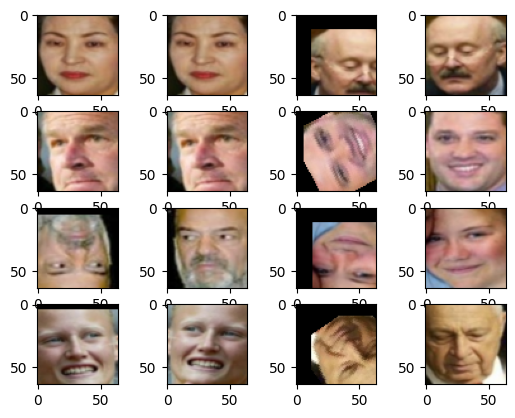

In [757]:
f = plt.figure()
for i in range(8):
    data, label = next(iter(train_dl))
    f.add_subplot(4,4,2*i+1)
    plt.imshow(data[0].to('cpu').permute(1, 2, 0))
    f.add_subplot(4,4,2*i+2)
    plt.imshow(label[0].to('cpu').permute(1, 2, 0))

In [767]:
from model import *
from loss import LogCoshLoss, PerceptualLoss

latent = 20
hidden = 100

model = AutoEncoder(NewEncoder(latent),NewDecoder(latent))
print('PARAMETERS: ',sum(p.numel() for p in model.parameters() if p.requires_grad))
print()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
# optim = torch.optim.Adagrad(model.to(device).parameters(),lr=1e-3,weight_decay=0.97)

trainer = Trainer(model, optim, device, train_dl, val_dl, lossfn=nn.BCELoss(reduction='sum'))
torch.cuda.empty_cache()
mse, kl, total = trainer.train_model(epochs=10,print_every=1000)

PARAMETERS:  36396971

EPOCH:  0
Iteration 0, loss = 203196.8438
KL DIV: 0.0583
Recon Loss: 203196.9062
Avg Recon Loss on Val: 199870.67857142858

EPOCH:  1
Iteration 0, loss = -861116062984537475383296.0000
KL DIV: 861116062984537475383296.0000
Recon Loss: 13179968.0000
Avg Recon Loss on Val: 12828733.714285715

EPOCH:  2
Iteration 0, loss = -265302262218392397152256.0000
KL DIV: 265302262218392397152256.0000
Recon Loss: 13106894.0000
Avg Recon Loss on Val: 12970573.714285715

EPOCH:  3
Iteration 0, loss = -9241497115828700049309696.0000
KL DIV: 9241497115828700049309696.0000
Recon Loss: 12914592.0000
Avg Recon Loss on Val: 13077395.42857143



KeyboardInterrupt: 

In [645]:
trainer.check_accuracy(loader=test_dl,model=model)

Avg Recon Loss on Val: 178354.92857142858


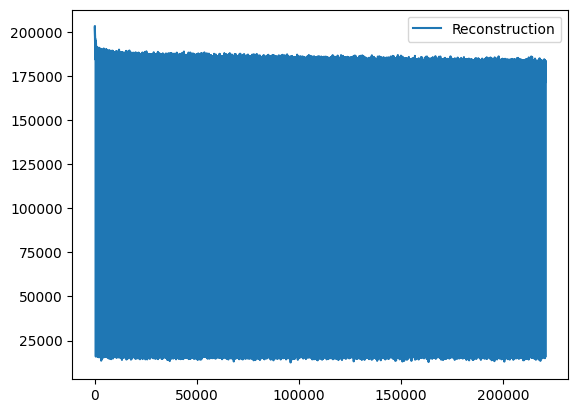

In [646]:
plt.plot(range(len(mse)),mse,label='Reconstruction')
plt.legend()

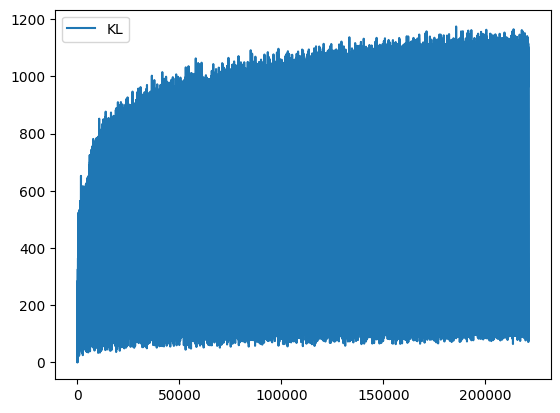

In [647]:
plt.plot(range(len(kl)),kl,label='KL')
plt.legend()

Text(0.5, 1.0, 'Reconstruction')

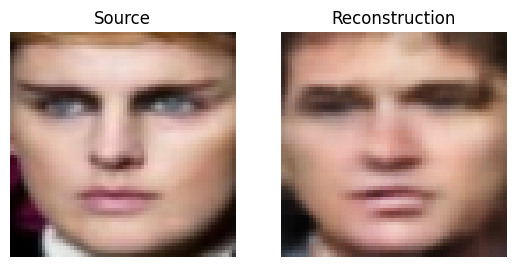

In [700]:
f = plt.figure()
tensor_image,_ = next(iter(test_dl))
f.add_subplot(1,2,1)
plt.imshow(tensor_image[0].permute(1, 2, 0))
plt.axis('off')
plt.title('Source')
model.eval()
with torch.no_grad():
    tensor_image = tensor_image[0].unsqueeze(0)
    scores,_ = model(tensor_image.to(device), eval=True)

f.add_subplot(1,2,2)
scores = scores.squeeze(0)
plt.imshow(scores.to('cpu').permute(1, 2, 0))
plt.axis('off')
plt.title('Reconstruction')

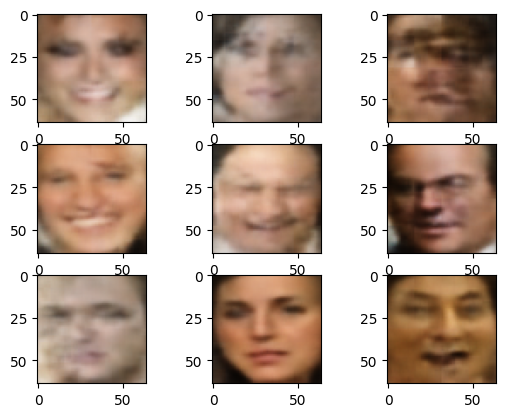

In [756]:
encoder = model.encoder
decoder = model.decoder
idx = np.random.randint(0,1000)
tensor_image,_ = next(iter(test_dl))
tensor_image = tensor_image[0].unsqueeze(0)
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()
with torch.no_grad():
    randomData = torch.Tensor(np.random.normal(0,1,(9,latent)))
    scores = model.decoder(randomData.to(device))
f = plt.figure()
for i in range(9):
    f.add_subplot(3,3,i+1)
    plt.imshow(scores[i].squeeze(0).to('cpu').permute(1, 2, 0))

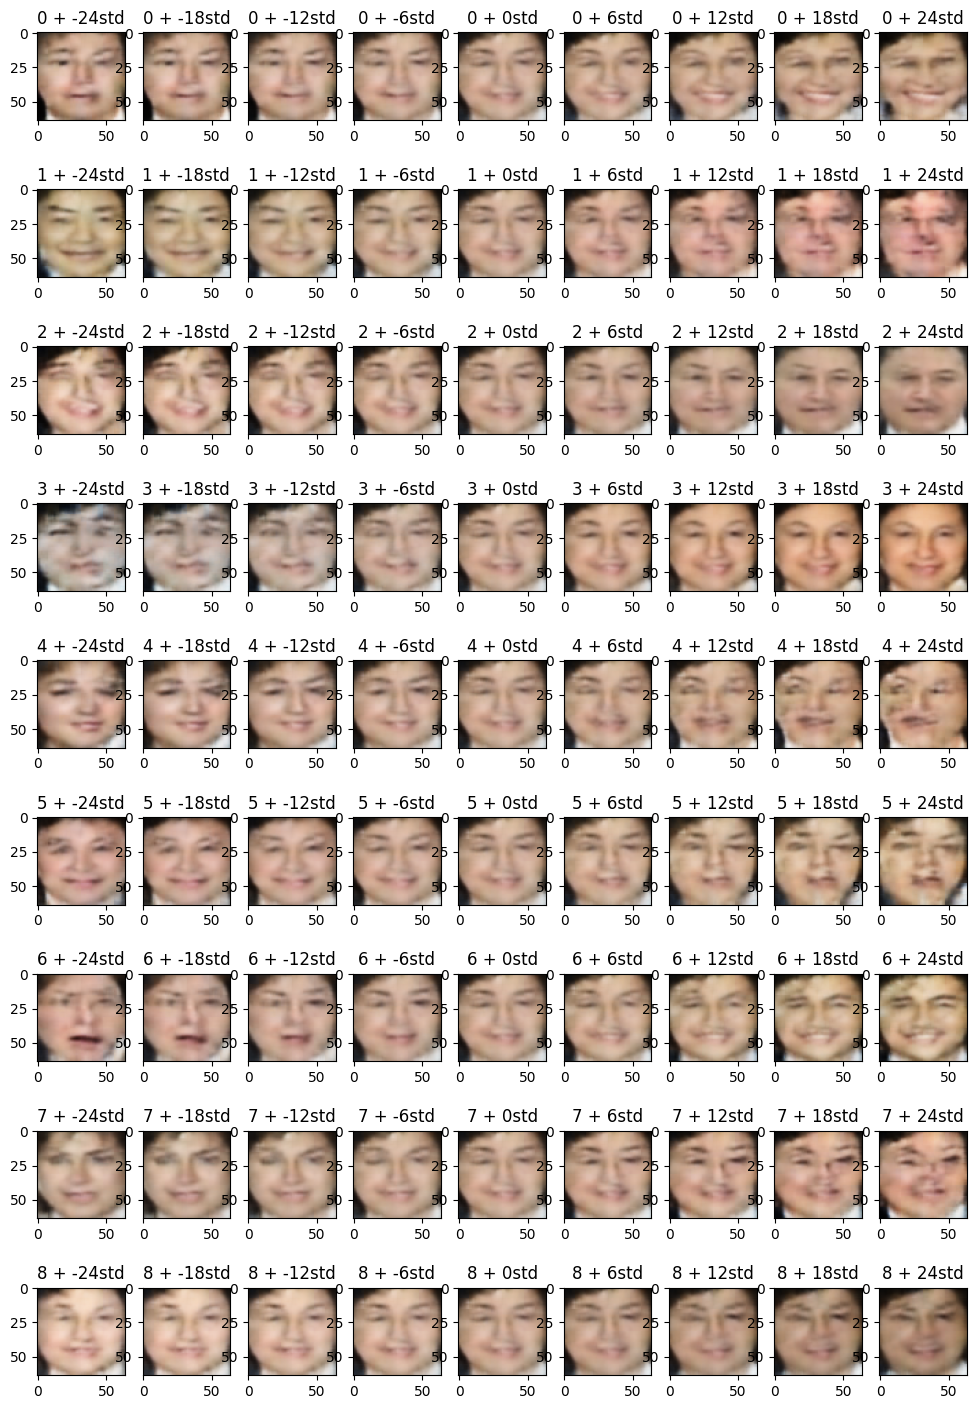

In [710]:
encoder = model.encoder
decoder = model.decoder

num_latents = 9
latent_offset = 0
f = plt.figure(figsize=(12,18))

# Get latent space of random image
tensor_image,_ = next(iter(test_dl))
tensor_image = tensor_image[0].unsqueeze(0)
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()

#Get different num standard deviations from mu
add = torch.arange(-4,5)*6

#for each of N latent spaces iterate thru stdevs
for latent_i in range(num_latents):
    for i in range(9):
        #generate new faces with each stdev
        randomData = latent_mu.clone().detach()
        with torch.no_grad():
            randomData[0][latent_i + latent_offset] = latent_mu[0][latent_i + latent_offset] + add[i] * torch.exp(0.5*latent_var[0][latent_i + latent_offset])
            scores = model.decoder(randomData.to(device))
        #plot it
        f.add_subplot(num_latents,9,(9*latent_i) + i+1)
        plt.imshow(scores[0].squeeze(0).to('cpu').permute(1, 2, 0))
        plt.title('{} + {}std'.format(latent_i + latent_offset,add[i]))

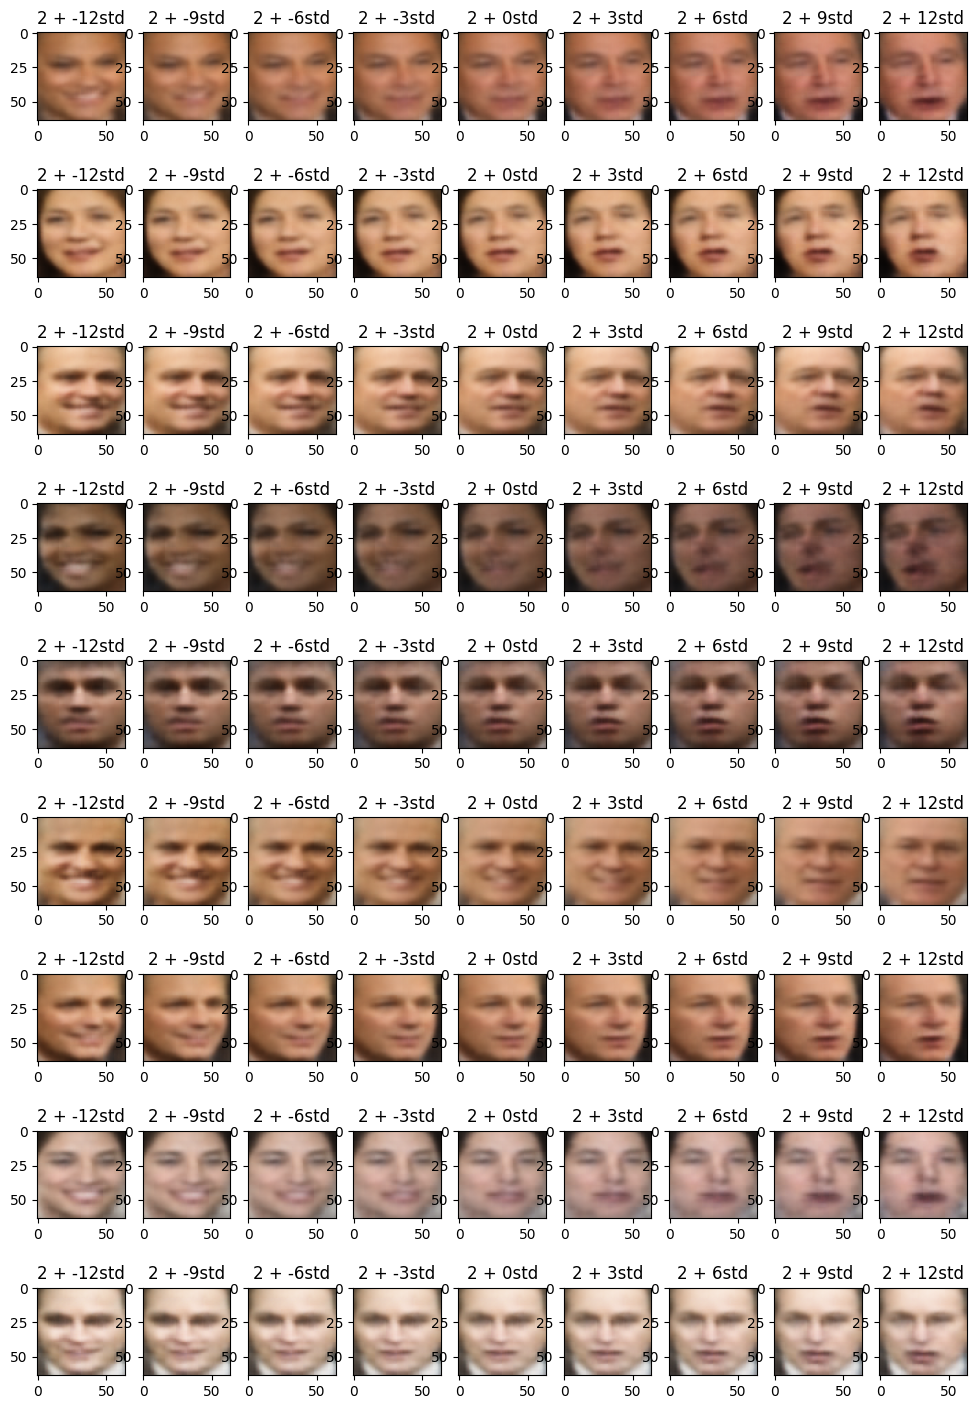

In [307]:
encoder = model.encoder
decoder = model.decoder

num_img = 9
latent_offset = 0
f = plt.figure(figsize=(12,18))

# Get latent space of random image
tensor_image,_ = next(iter(test_dl))
tensor_image = tensor_image[:num_img]
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()

#Get different num standard deviations from mu
add = torch.arange(-4,5)*3

#for each of N latent spaces iterate thru stdevs
for img in range(9):
    for i in range(9):
        #generate new faces with each stdev
        randomData = latent_mu.clone().detach()
        with torch.no_grad():
            randomData[img][2] = latent_mu[img][2] + add[i] * torch.exp(0.5*latent_var[img][2])
            scores = model.decoder(randomData.to(device))
        #plot it
        f.add_subplot(num_latents,9,(9*img) + i+1)
        plt.imshow(scores[img].squeeze(0).to('cpu').permute(1, 2, 0))
        plt.title('{} + {}std'.format(latent_i + latent_offset,add[i]))

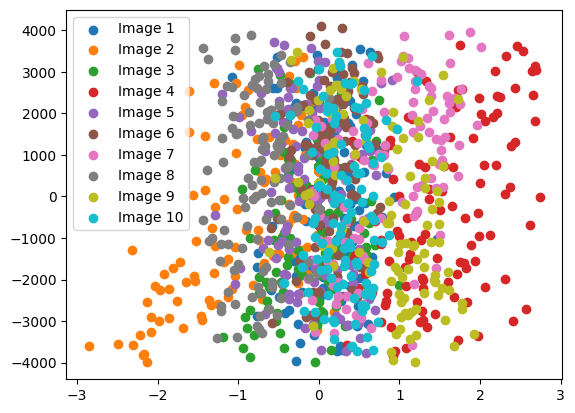

In [766]:
import torchvision.transforms as T
from sklearn import manifold 

tsne = manifold.TSNE(
    n_components=2,
    perplexity=200,
    n_iter=5000
)

encoder = model.encoder

train_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((64,64)),
    T.RandomAffine(degrees = 0, translate = (0.25, 0.25)),
    T.ToTensor()
])

img,_ = next(iter(test_dl))

for i in range(10):
    latent_dist = np.zeros((240,20))
    for j in range(24):
        tensor_image = train_transform(img[i])
        with torch.no_grad():
            latent_mu,latent_var = encoder(tensor_image.to(device).unsqueeze(0))
        latent_var = latent_var.to('cpu').detach()
        latent_mu = latent_mu.to('cpu').detach()
        for x in range(10):
            latent_dist[x*j] = torch.distributions.Normal(latent_mu[0],torch.exp(0.5*latent_var[0])).rsample()
    tsne_points = tsne.fit_transform(latent_dist)
    plt.scatter(latent_dist[:,0],tsne_points[:,0])
    plt.legend([
        'Image 1',
        'Image 2',
        'Image 3',
        'Image 4',
        'Image 5',
        'Image 6',
        'Image 7',
        'Image 8',
        'Image 9',
        'Image 10',
    ])

In [657]:
torch.save(model,'500.model')

In [768]:
model = torch.load('./500_EPOCH/Transform/transform.model')

In [113]:
import gc 
model = 1
del model 
gc.collect()
plt.close()
with torch.no_grad():

    torch.cuda.empty_cache()

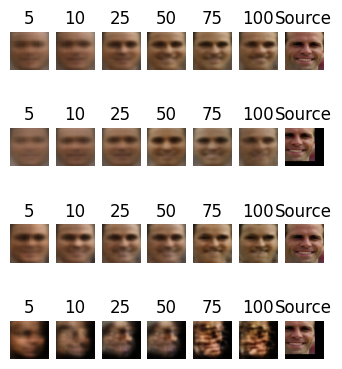

In [762]:
import cv2

f = plt.figure()

img,_ = next(iter(test_dl))

# img = cv2.imread('Screenshot 2023-12-05 105400.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = T.ToTensor()(T.Resize((64,64))(T.ToPILImage()(img))).unsqueeze(0)

img = img[0].unsqueeze(0).to(device)
img_t = train_transform(img[0]).unsqueeze(0).to(device)




f.add_subplot(4,11,7)
plt.imshow(img.to('cpu').squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Source')
f.add_subplot(4,11,18)
plt.imshow(img_t.to('cpu').squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Source')
f.add_subplot(4,11,29)
plt.imshow(img.to('cpu').squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Source')
f.add_subplot(4,11,40)
plt.imshow(img_t.to('cpu').squeeze(0).permute(1, 2, 0))
plt.axis('off')
plt.title('Source')

# f.add_subfigure()
path = './{}_EPOCH/Transform/transform.model'
epochs = [5,10,25,50,75,100]
for i in range(len(epochs)):
    try:
        f.add_subplot(4,11,i+1)
        m = torch.load(path.format(epochs[i]))
        with torch.no_grad():
            scores,_ = m(img,eval=True)
        scores = scores.squeeze(0)
        plt.imshow(scores.to('cpu').permute(1, 2, 0))
        plt.title(epochs[i])
        plt.axis('off')
    except Exception as e:
        print(e)

for i in range(len(epochs)):
    try:
        f.add_subplot(4,11,i+12)
        m = torch.load(path.format(epochs[i]))
        with torch.no_grad():
            scores,_ = m(img_t,eval=True)
        scores = scores.squeeze(0)
        plt.imshow(scores.to('cpu').permute(1, 2, 0))
        plt.title(epochs[i])
        plt.axis('off')
    except Exception as e:
        print(e)

path = './{}_EPOCH/Vanilla/vanilla.model'
epochs = [5,10,25,50,75,100]
for i in range(6):
    try:
        f.add_subplot(4,11,i+23)
        m = torch.load(path.format(epochs[i]))
        with torch.no_grad():
            scores,_ = m(img,eval=True)
        scores = scores.squeeze(0)
        plt.imshow(scores.to('cpu').permute(1, 2, 0))
        plt.title(epochs[i])
        plt.axis('off')
    except Exception as e:
        print(e)

for i in range(6):
    try:
        f.add_subplot(4,11,i+34)
        m = torch.load(path.format(epochs[i]))
        with torch.no_grad():
            scores,_ = m(img_t,eval=True)
        scores = scores.squeeze(0)
        plt.imshow(scores.to('cpu').permute(1, 2, 0))
        plt.title(epochs[i])
        plt.axis('off')
    except Exception as e:
        print(e)

torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 3, 64, 64])


Text(0.5, 1.0, 'Reconstruction')

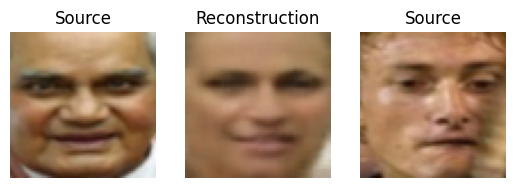

In [775]:
encoder = model.encoder
decoder = model.decoder


f = plt.figure()
tensor_image,_ = next(iter(test_dl))
f.add_subplot(1,3,1)
plt.imshow(tensor_image[0].permute(1, 2, 0))
plt.axis('off')
plt.title('Source')
f.add_subplot(1,3,3)
plt.imshow(tensor_image[1].permute(1, 2, 0))
plt.axis('off')
plt.title('Source')
encoder.eval()
with torch.no_grad():
    tensor_image = tensor_image[:2]
    scores,_ = encoder(tensor_image.to(device))
    print(scores.shape)
    avg = (scores[0]+scores[1])/2
    print(avg.shape)
    scores = decoder(avg.unsqueeze(0))

f.add_subplot(1,3,2)
print(scores.shape)
scores = scores.squeeze(0)
plt.imshow(scores.to('cpu').permute(1, 2, 0))
plt.axis('off')
plt.title('Reconstruction')